# Понижение размерности признакого пространства

В задачах классификации или регресии объекты выборки могут быть представлены многомерными данным из пространства с сложной структурой, например: изображениями, текстом, звуком и т.д. Даже простые табличные данные могут иметь высокую размерность признакого пространства, в котором работать сложно.

Возникает задача извлечения из входных многомерных данных признаков, которые информативны для дальнейшего решения задачи машинного обучения.

----------
# Пример простого алгоритма - рассмотрим PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, datasets
import pylab as pl
import seaborn
seaborn.set()

%matplotlib inline

![IRIS dataset](https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Iris_dataset_scatterplot.svg/2000px-Iris_dataset_scatterplot.svg.png)

In [2]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
print(X.shape, y.shape)

(150, 4) (150,)


In [3]:
from sklearn.decomposition import PCA

In [4]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [5]:
X_reduced = pca.transform(X)
print("Reduced dataset shape:", X_reduced.shape)

Reduced dataset shape: (150, 2)


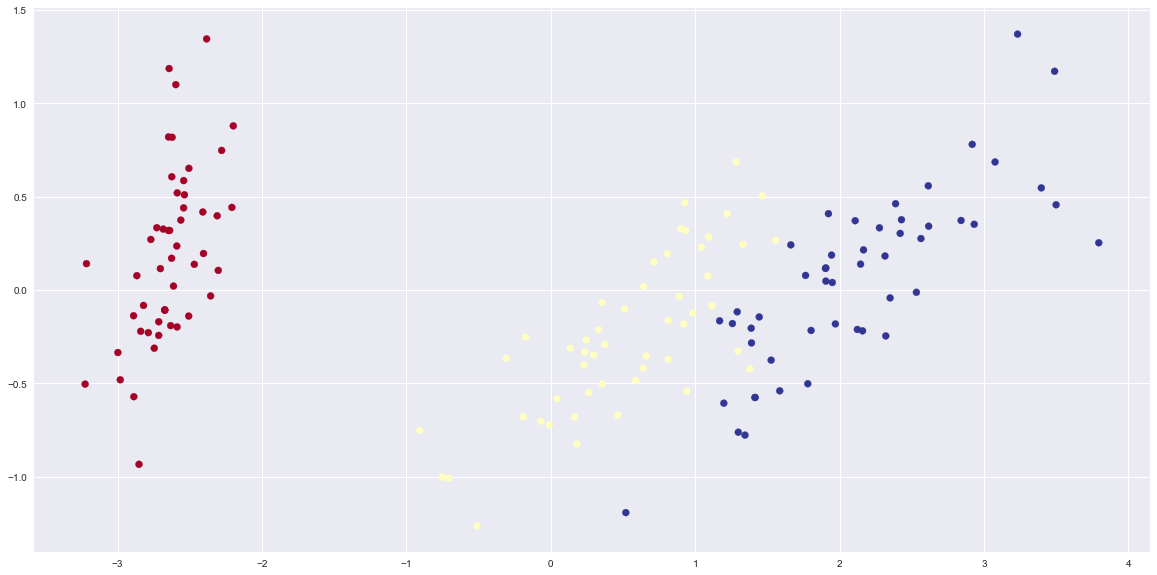

In [6]:
pl.figure(figsize=(20, 10))
pl.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='RdYlBu');

In [7]:
pca.explained_variance_ratio_

array([ 0.92461621,  0.05301557])

-----------
# Пример алгоритма на основе нейронных сетей - рассмотрим Автоэнкодер

![Autoencoder](https://cdn-images-1.medium.com/max/1574/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

## Input: $ x \in R^n $

## Encoder: $ Code = ReLu(ReLu(ReLu(x W_1 + b_1) W_2 + b_2)W_3 + b_3) $
## $Code \in R^m$, $m << n$

## Decoder: $Output = ReLu(ReLu(ReLu(x W_1' + b_1') W_2' + b_2')W_3' + b_3') $
## $Output \in R^n$, $ |Output - x|_2 \rightarrow 0 $

-----------
## Рассмотрим пример применения Автоэнкодера с сложным данным

In [8]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist

Using TensorFlow backend.
/Users/kovalenko/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
# Размер батча данных и количество эпох
batch_size = 128
nb_epoch = 10

In [10]:
# Зашрузим данные MNIST
(x_train, _), (x_test, _) = mnist.load_data()

# Нормализуем
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Преобразуем картинки в вектора 
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [11]:
# Добавим шум к данным
corruption_level = 0.3

x_train_noisy = x_train + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [12]:
# Соберем модель автоэнкодера
input_img = Input(shape=(x_train.shape[1],))

# Размер скрытого слоя
nb_hidden = 500
encoded = Dense(nb_hidden, activation='relu')(input_img)

decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 784)               392784    
Total params: 785,284
Trainable params: 785,284
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=nb_epoch, 
                batch_size=batch_size, 
                shuffle=True, 
                verbose=1,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.1032 - val_loss: 0.1013
Epoch 2/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.1020 - val_loss: 0.1002
Epoch 3/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1009 - val_loss: 0.0992
Epoch 4/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.1000 - val_loss: 0.0984
Epoch 5/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0991 - val_loss: 0.0975
Epoch 6/10
60000/60000 [==============================] - 8s 139us/step - loss: 0.0983 - val_loss: 0.0968
Epoch 7/10
60000/60000 [==============================] - 10s 173us/step - loss: 0.0976 - val_loss: 0.0961
Epoch 8/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.0969 - val_loss: 0.0955
Epoch 9/10
60000/60000 [==============================] - 8s 139us/step - loss: 0.0963 - val_loss: 0.

In [16]:
# Decode test images 
decoded_imgs = autoencoder.predict(x_test_noisy)

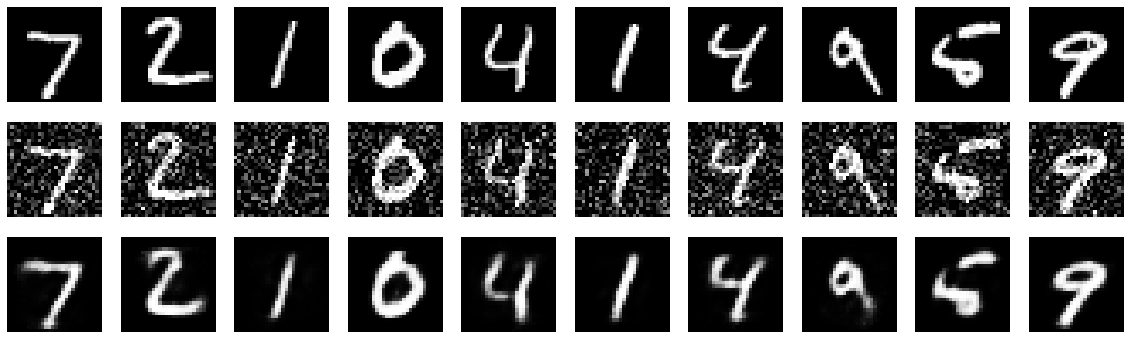

In [23]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original with noise
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## На картинке:
## 1 ряд - оригинальные изображения
## 2 ряд - оригинальные изображения + шум, к ним применяли автоэнкодер
## 3 ряд - реконструкция, выход с автоэнкодера

------